In [ ]:
!wget https://raw.githubusercontent.com/alimbekovKZ/ods_homework/master/data/wiki_machine_learning.csv

--2020-11-09 11:42:05--  https://raw.githubusercontent.com/alimbekovKZ/ods_homework/master/data/wiki_machine_learning.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31043 (30K) [text/plain]
Saving to: ‘wiki_machine_learning.csv’

wiki_machine_learni 100%[===================>]  30.32K  --.-KB/s    in 0.004s  

2020-11-09 11:42:06 (7.81 MB/s) - ‘wiki_machine_learning.csv’ saved [31043/31043]



In [ ]:
import torch
import os

import numpy as np

import pandas as pd

from tqdm import tqdm

import seaborn as sns

from pylab import rcParams

import matplotlib.pyplot as plt

from matplotlib import rc

from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import register_matplotlib_converters

from torch import nn, optim

In [ ]:
df = pd.read_csv('wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [ ]:
df.date = pd.to_datetime(df.date)

In [ ]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)

In [ ]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']

In [ ]:
train_data = df[:-predictions]

test_data = df[-predictions:]

train_data.shape

(353, 2)

In [ ]:
test_data.shape

(30, 2)

In [ ]:
train_data

,ds,y
81,2015-01-01,1414
80,2015-01-02,1920
79,2015-01-03,1338
78,2015-01-04,1404
77,2015-01-05,2264
...,...,...
358,2015-12-17,2870
363,2015-12-18,2475
364,2015-12-19,1659
344,2015-12-20,1534


In [ ]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data.y, axis=1))

train_data = scaler.transform(np.expand_dims(train_data.y, axis=1))

test_data = scaler.transform(np.expand_dims(test_data.y, axis=1))

In [ ]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [ ]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
X_train.shape

torch.Size([347, 5, 1])

In [ ]:
X_test.shape

torch.Size([24, 5, 1])

In [ ]:
class vanillaLSTM(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(vanillaLSTM, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [ ]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [ ]:
model = vanillaLSTM(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 49.68014907836914 test loss: 4.296288967132568
Epoch 10 train loss: 11.760491371154785 test loss: 1.2036906480789185
Epoch 20 train loss: 8.300226211547852 test loss: 0.817054033279419
Epoch 30 train loss: 8.358680725097656 test loss: 0.7815330624580383
Epoch 40 train loss: 8.329060554504395 test loss: 0.8130291700363159
Epoch 50 train loss: 8.317010879516602 test loss: 0.7833806276321411


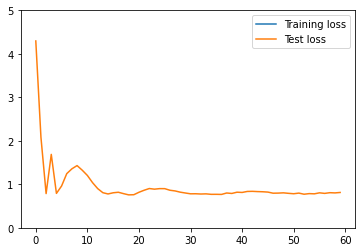

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

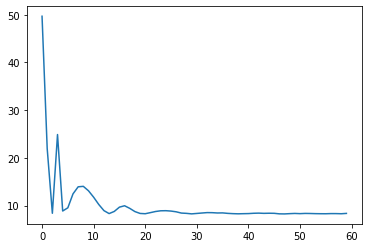

In [ ]:
plt.plot(train_hist, label="Training loss")

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
DAYS_TO_PREDICT = 25

with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
y_test.shape

torch.Size([25, 1])

In [ ]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
true_cases.shape

(25,)

In [ ]:
predicted_cases.shape

(25,)

In [ ]:
print(mean_absolute_percentage_error(true_cases, predicted_cases))
print(mean_absolute_percentage_error(sum(true_cases), sum(predicted_cases)))

30.857965450091836
6.756520298896366
